In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

from __future__ import print_function
from collections import OrderedDict

import os
import sys
import timeit
import pickle

import scipy.io as sio
import numpy as np
import theano
import theano.tensor as T

sys.path.insert(0, "/home/cwhuang/DVTL/Model/")
import nnet as nn
import criteria	as er
import util
import VFAE

import OfficeFeaturePlot as fp

number of minibatch at one epoch: 10, batch size source : 57, target : 48 
 validation size, S:330, T:280, test size, S:220, T:190
... building the model
Encoder1_share is constructed with hidden layer number 0
Encoder1_mu is constructed with hidden layer number 0
Encoder1_sigma is constructed with hidden layer number 0
Encoder3_pi is constructed with hidden layer number 0
Encoder2_share is constructed with hidden layer number 0
Encoder2_mu is constructed with hidden layer number 0
Encoder2_sigma is constructed with hidden layer number 0
Decoder1_share is constructed with hidden layer number 0
Decoder1_mu is constructed with hidden layer number 0
Decoder1_sigma is constructed with hidden layer number 0
Decoder2_share is constructed with hidden layer number 0
Decoder2_mu is constructed with hidden layer number 0
Decoder2_sigma is constructed with hidden layer number 0
Encoder1_share is constructed with hidden layer number 0
Encoder1_mu is constructed with hidden layer number 0
Encoder1_

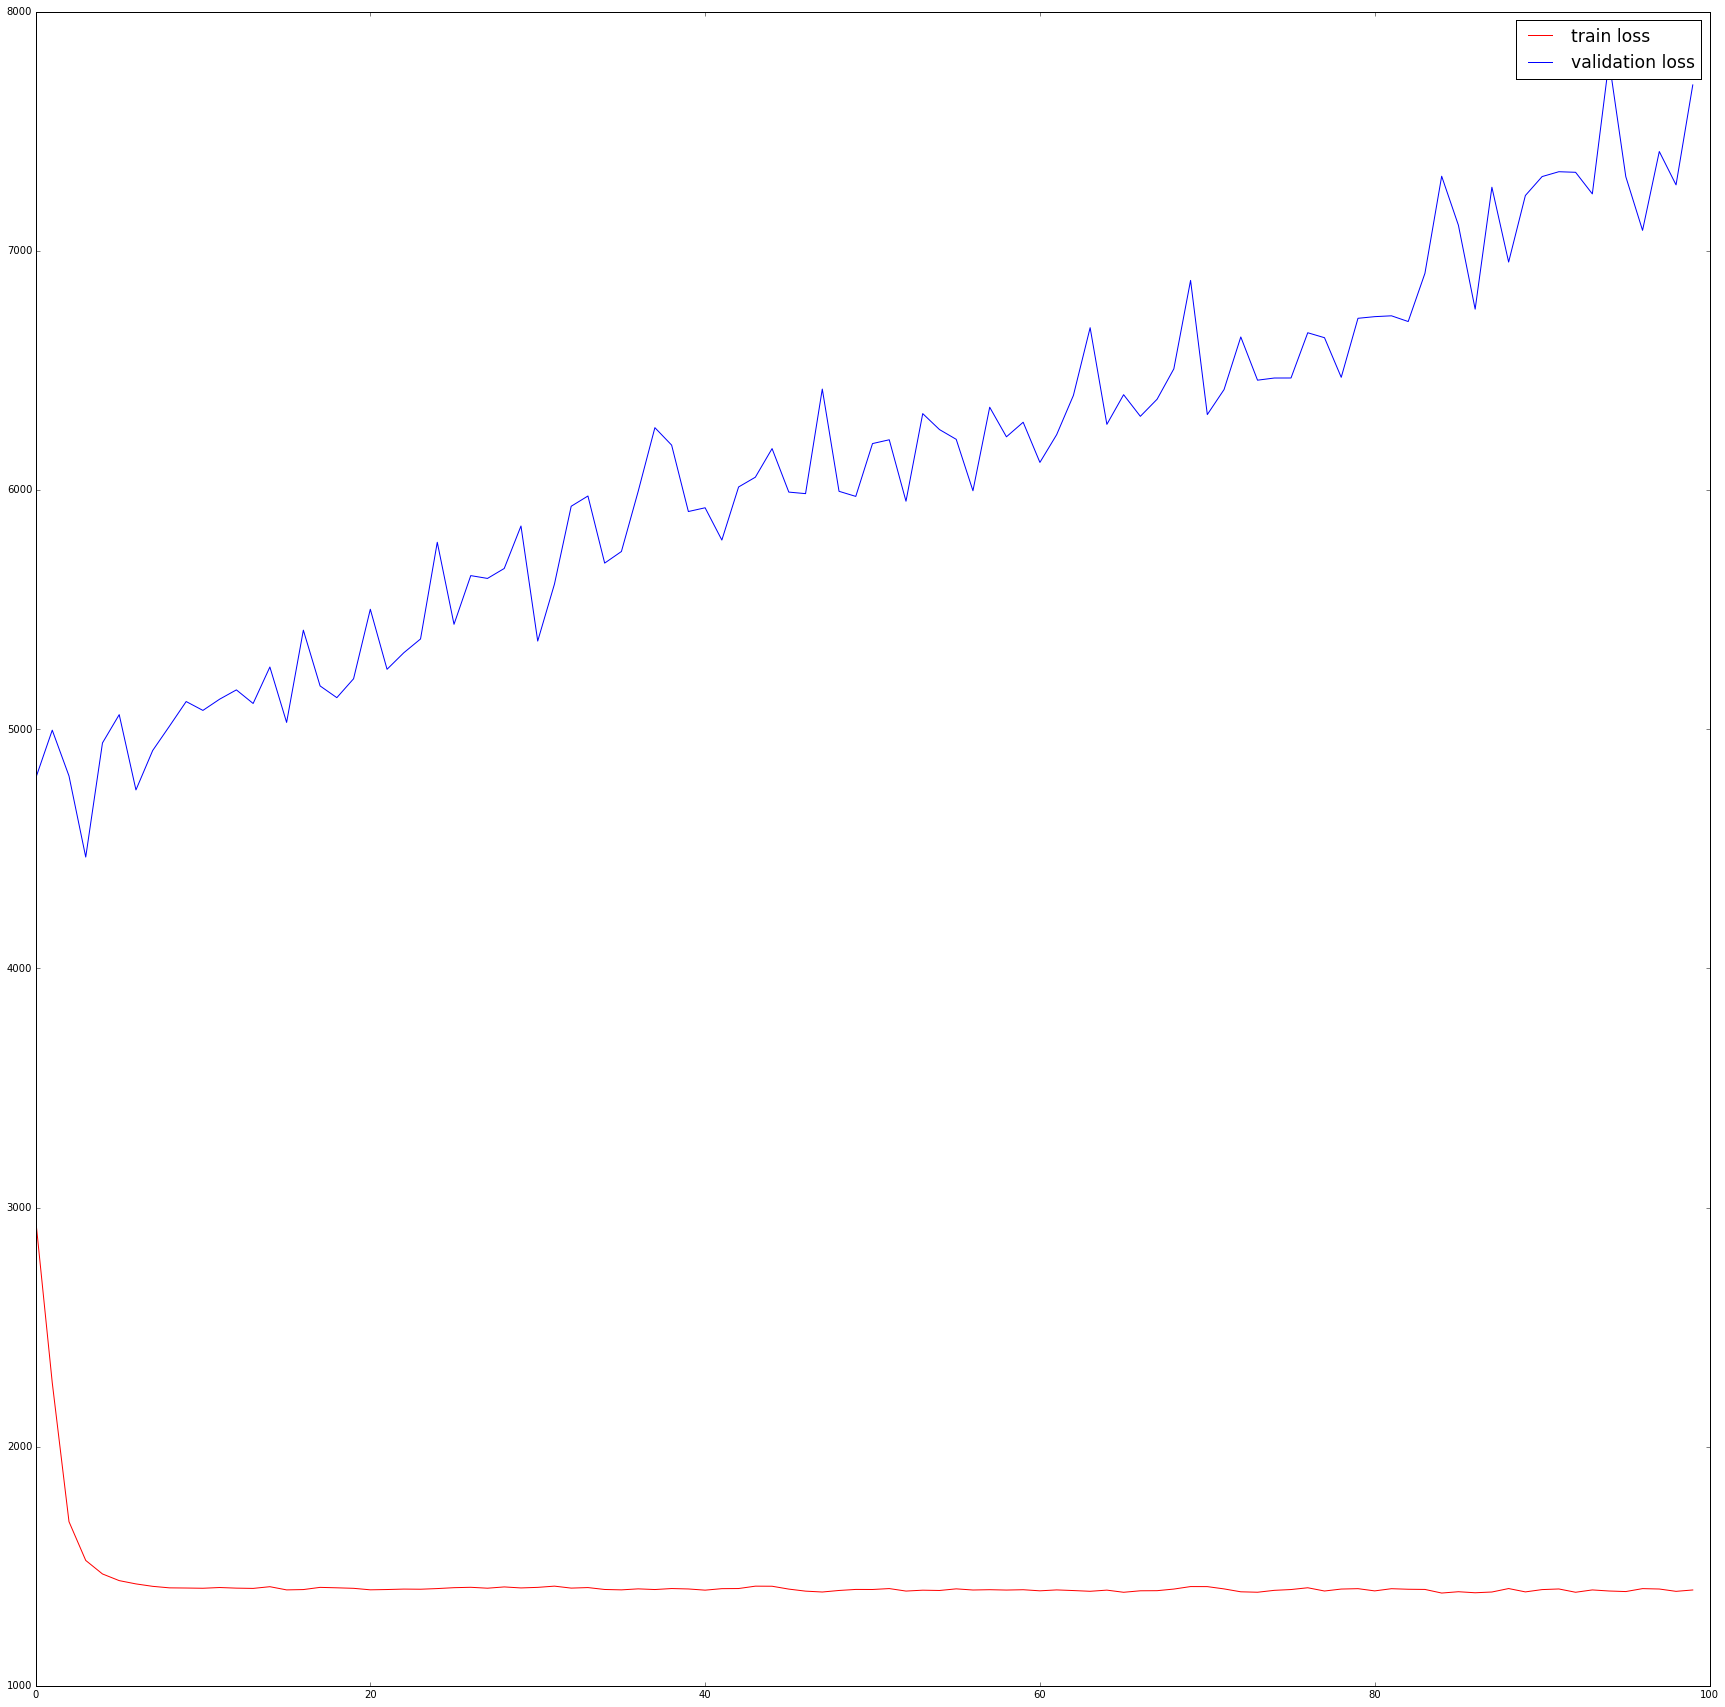

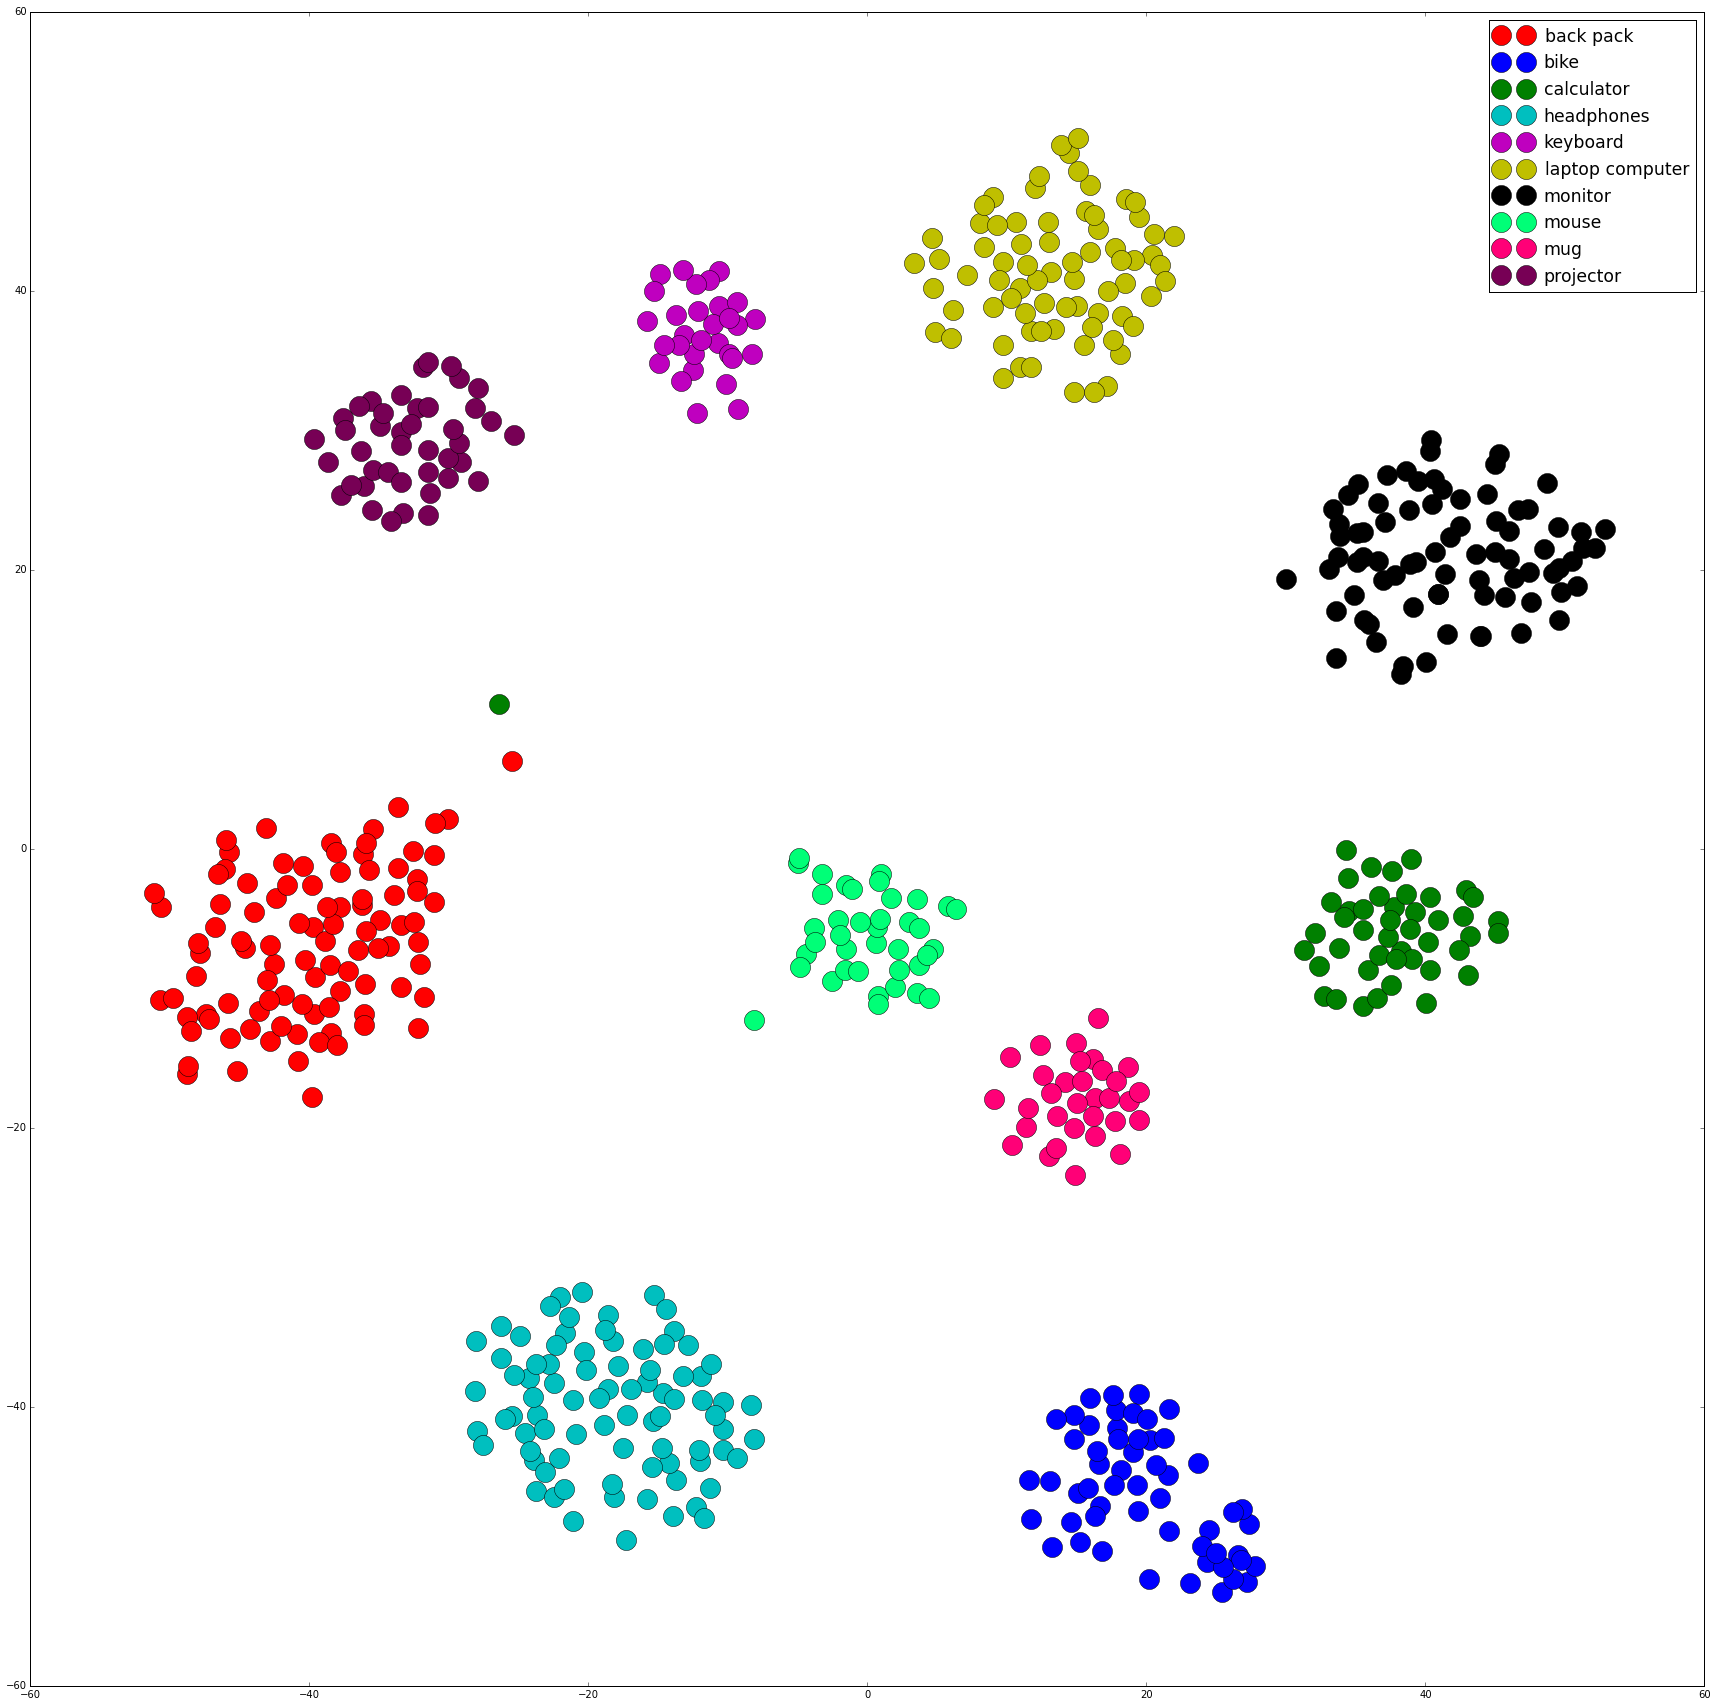

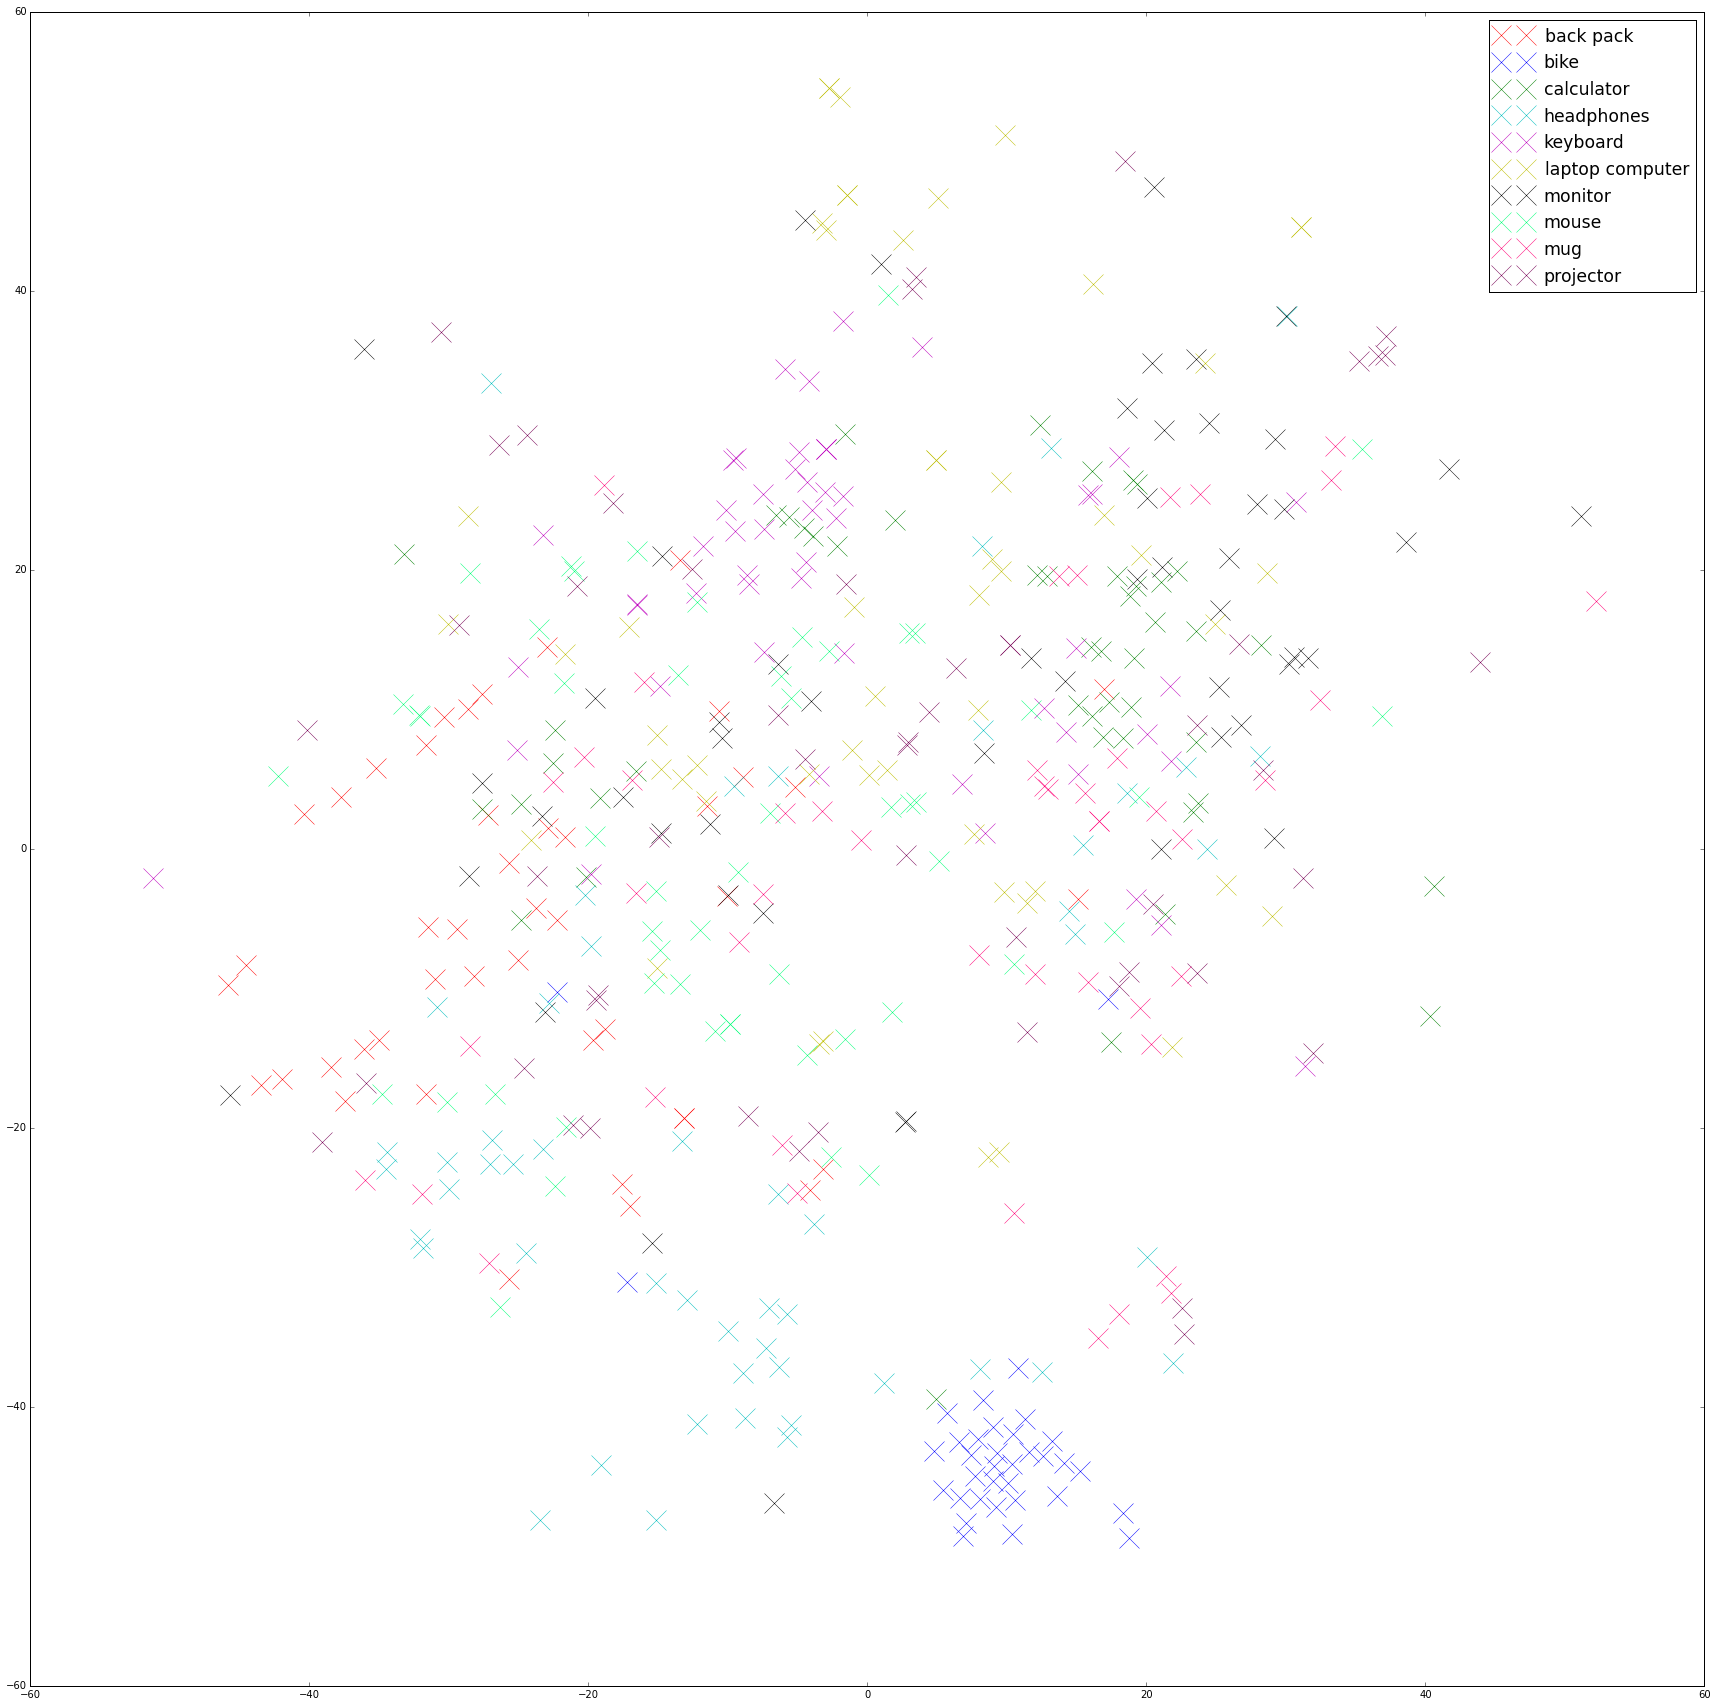

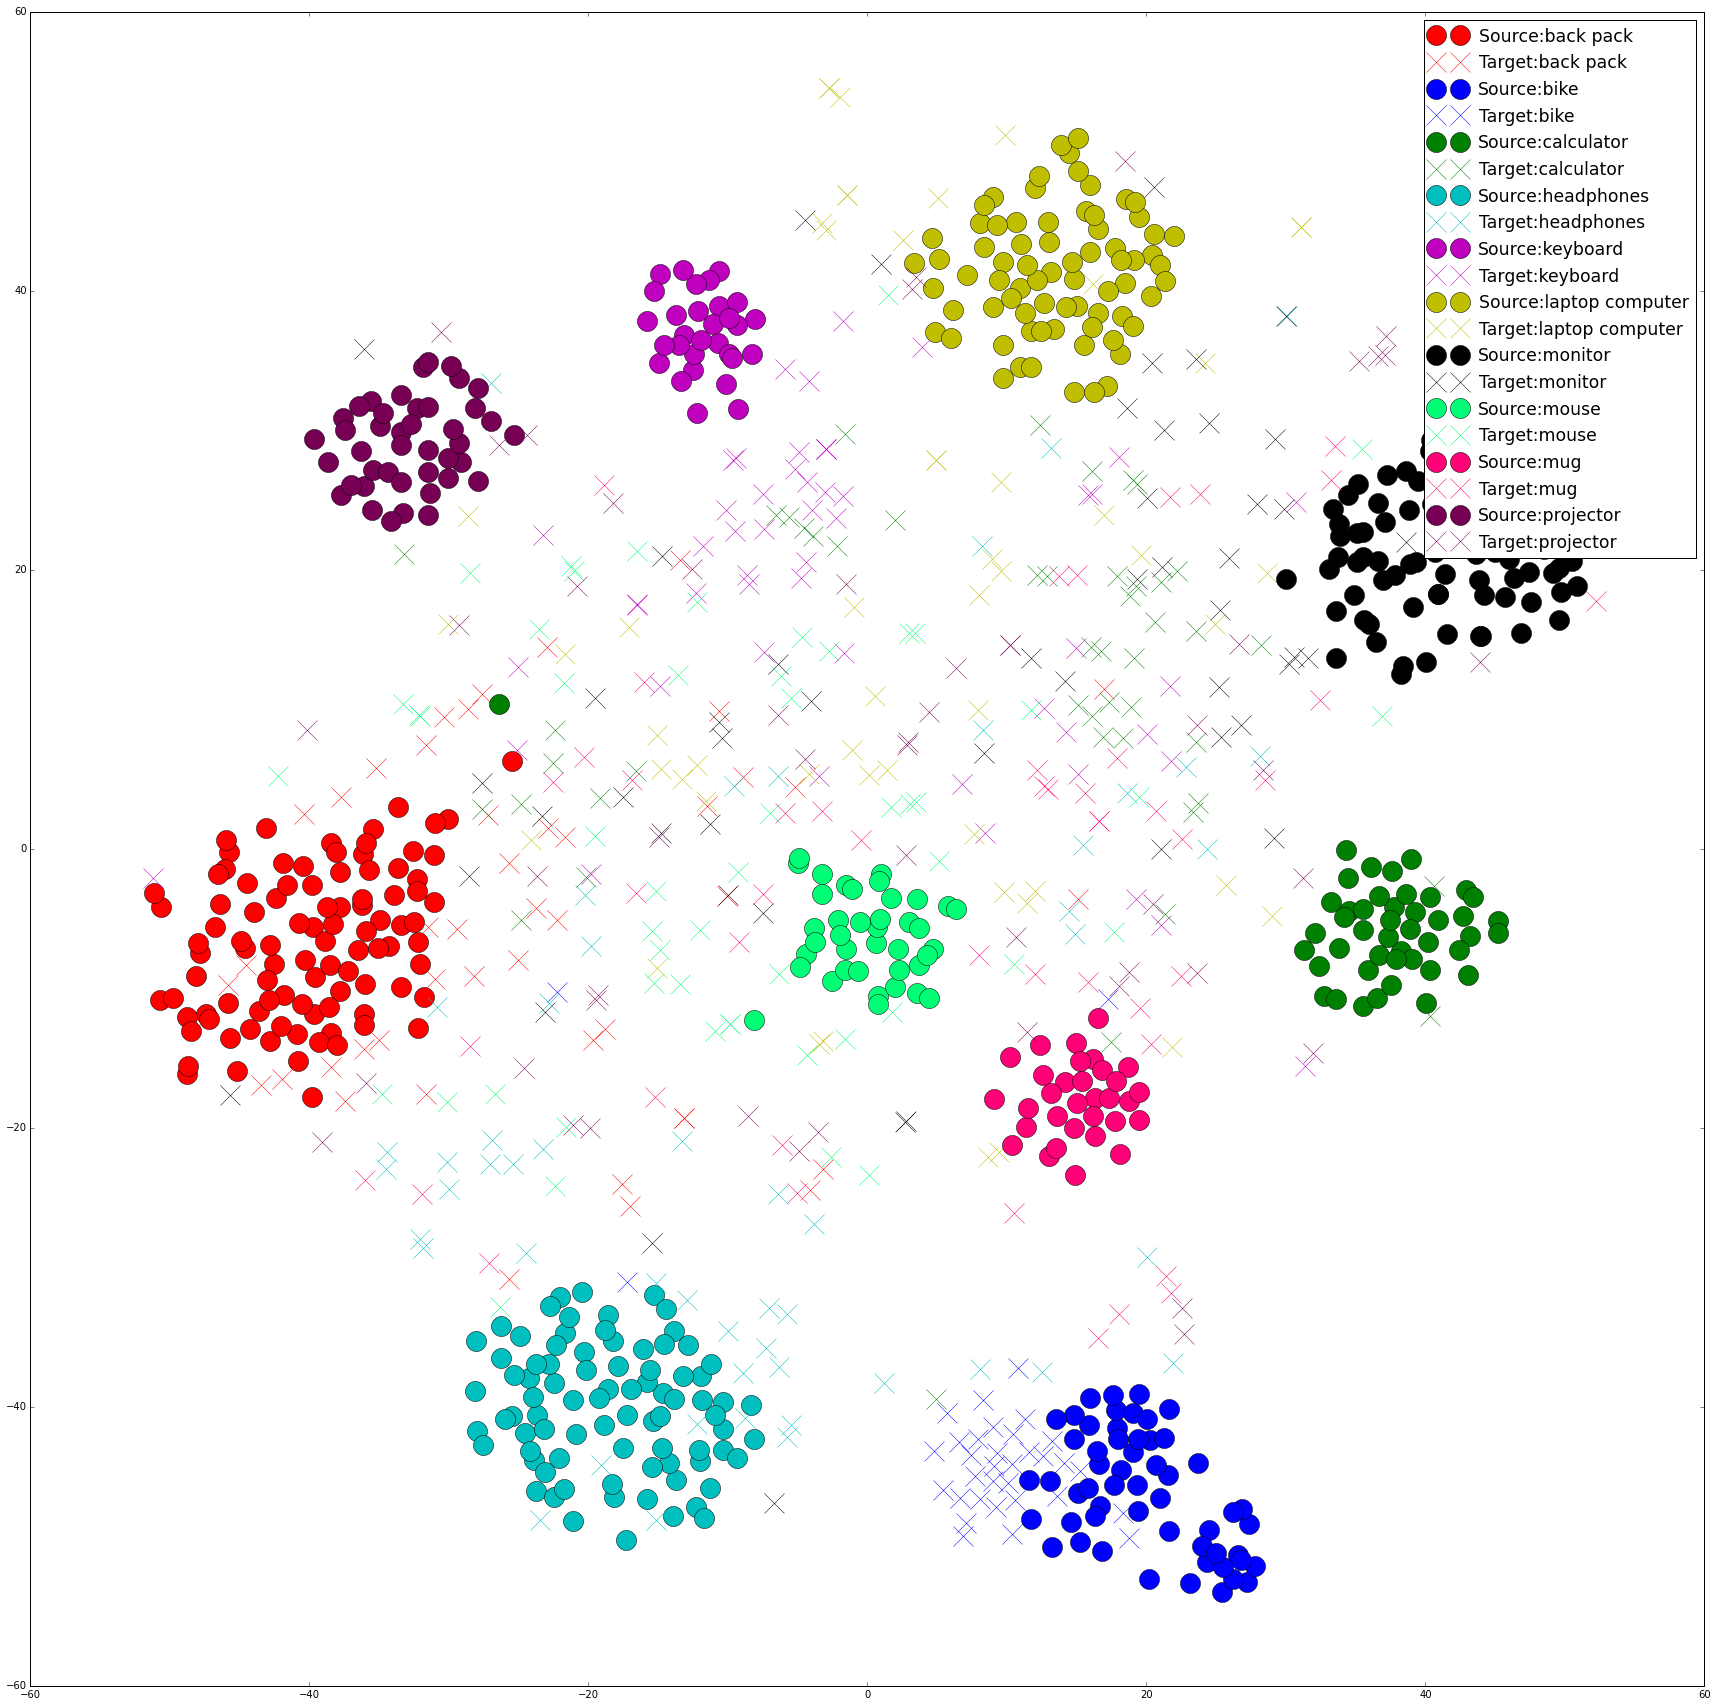

In [4]:
'''Model Construct'''
if __name__ == '__main__':
    
    source_file = '/home/cwhuang/DVTL/Dataset/Office/Caltech10_SURF_L10.npy'
    target_file = '/home/cwhuang/DVTL/Dataset/Office/amazon_SURF_L10.npy'

    source_data = np.load(source_file)
    target_data = np.load(target_file)
    
    #source_data, target_data = DataDuplicate.DataDuplicate(source_data, target_data)    
    
    ########################################################################
    ###                        Coefficient Initial                       ###
    ########################################################################        
    
    coef = VFAE.VFAE_coef(
        alpha = 3000,
        beta = 1000,
        chi = 1,
        D = 500,
        L = 10,
        optimize = 'Adam_update'     
    )    
    
    x_dim = 800
    y_dim = 10    
    d_dim = 2
    z_dim = 100                #dimension of latent feature
    a_dim = 50               #dimension of prior of latent feature    
    h_zy_dim = 300             #dimension of hidden unit  
    h_ay_dim = 70
    h_y_dim = 30
    learning_rate = 0.005
    activation = T.nnet.sigmoid

    struct = VFAE.VFAE_struct()    
    encoder_template = nn.NN_struct()


    struct.encoder1.share.layer_dim = [x_dim+d_dim, h_zy_dim]
    struct.encoder1.share.activation = [activation]
    struct.encoder1.share.learning_rate = [learning_rate, learning_rate]
    struct.encoder1.share.decay = [1, 1]                

    struct.encoder1.mu.layer_dim = [h_zy_dim, z_dim]
    struct.encoder1.mu.activation = [None]
    struct.encoder1.mu.learning_rate = [learning_rate]
    struct.encoder1.mu.decay = [1, 1]      
    struct.encoder1.sigma.layer_dim = [h_zy_dim, z_dim]
    struct.encoder1.sigma.activation = [None]
    struct.encoder1.sigma.learning_rate = [learning_rate, learning_rate]
    struct.encoder1.sigma.decay = [1, 1]   
    
    struct.encoder2.share.layer_dim = [z_dim+y_dim, h_ay_dim]
    struct.encoder2.share.activation = [ activation]
    struct.encoder2.share.learning_rate = [learning_rate, learning_rate]
    struct.encoder2.share.decay = [1, 1]                
    struct.encoder2.mu.layer_dim = [h_ay_dim, a_dim]
    struct.encoder2.mu.activation = [None]
    struct.encoder2.mu.learning_rate = [learning_rate, learning_rate]
    struct.encoder2.mu.decay = [1, 1]      
    struct.encoder2.sigma.layer_dim = [h_ay_dim, a_dim]
    struct.encoder2.sigma.activation = [None]
    struct.encoder2.sigma.learning_rate = [learning_rate, learning_rate]
    struct.encoder2.sigma.decay = [1, 1]
    
    '''
    struct.encoder3.layer_dim = [z_dim, h_y_dim, y_dim]
    struct.encoder3.activation = [activation, T.nnet.softmax]   
    struct.encoder3.learning_rate = [learning_rate, learning_rate]
    struct.encoder3.decay = [1, 1]     
    '''
    
    struct.encoder3.layer_dim = [z_dim, y_dim]
    struct.encoder3.activation = [T.nnet.softmax]   
    struct.encoder3.learning_rate = [learning_rate, learning_rate]
    struct.encoder3.decay = [1, 1]     
    
    struct.decoder1.share.layer_dim = [z_dim+d_dim, h_zy_dim]
    struct.decoder1.share.activation = [activation]
    struct.decoder1.share.learning_rate = [learning_rate, learning_rate]
    struct.decoder1.share.decay = [1, 1]                
    struct.decoder1.mu.layer_dim = [h_zy_dim, x_dim]
    struct.decoder1.mu.activation = [None]
    struct.decoder1.mu.learning_rate = [learning_rate, learning_rate]
    struct.decoder1.mu.decay = [1, 1]      
    struct.decoder1.sigma.layer_dim = [h_zy_dim, x_dim]
    struct.decoder1.sigma.activation = [None]
    struct.decoder1.sigma.learning_rate = [learning_rate, learning_rate]
    struct.decoder1.sigma.decay = [1, 1]      
    
    struct.decoder2.share.layer_dim = [a_dim+y_dim, h_ay_dim]
    struct.decoder2.share.activation = [activation]
    struct.decoder2.share.learning_rate = [learning_rate, learning_rate]
    struct.decoder2.share.decay = [1, 1]                
    struct.decoder2.mu.layer_dim = [h_ay_dim, z_dim]
    struct.decoder2.mu.activation = [None]
    struct.decoder2.mu.learning_rate = [learning_rate, learning_rate]
    struct.decoder2.mu.decay = [1, 1]      
    struct.decoder2.sigma.layer_dim = [h_ay_dim, z_dim]
    struct.decoder2.sigma.activation = [None]
    struct.decoder2.sigma.learning_rate = [learning_rate, learning_rate]
    struct.decoder2.sigma.decay = [1, 1]      
    
    isMMD = 'MMD_'
    if coef.beta == 0:
        isMMD = ''                
    description = 'Office_VFAE_%s%s' % (isMMD, coef.optimize)
    
    features_model, test_model, trained_param = VFAE.VFAE_training(
        source_data=source_data,
        target_data=target_data,
        n_train_batches=10,
        n_epochs=100,
        struct = struct,
        coef = coef,
        description = description
    )
    
    fp.features_plot(features_model, test_model, source_data, target_data, description) 